In [1]:
from empirical_learning.historical_learning import perform_historical_learning
from empirical_learning.utils import *
from empirical_learning.plot_functions import *

For a given volatility index $v$ and a market index $S$, for a given `setting` which is a list of tuples `(i,j)` or `(i, (j_1,..., j_{n_i}))`, for each timestep $t$ (in days):
$$
r_t = \frac{S_t - S_{t-1}}{S_{t-1}} \\
R_{t,i} = \sum_{t_l \leq t} K_i(t-t_l)r_{t_l}^i
$$

Then the model estimates the volatility as
$$
v_t^p = \beta_0 + \sum_{i} \sum_{j\in\{j_1,\dots, j_{n_i}\}} \beta_{i,j} R_{t,i}^j
$$
Note: when there is only one $j$ associated to $i$, $\beta_{i,j}$ is simply noted $\beta_i$.


For example, the linear model we suggest is defined with `p=1`, `setting=[(1,1), (2,1/2)]`, resulting in
$$
v_t = \beta_0 + \beta_1 R_{t,1} + \beta_2 R_{t,2}^{1/2}
$$
The model (M3) will be defined by `p=2`, `setting=[(1,(1,2))]`, resulting in
$$
v_t = \beta_0 + \beta_{1,1} R_{t,1} + \beta_{1,2} R_{t,1}^2
$$

Note that there is one kernel per $i$. The kernels are either time-shifted power-laws or convex combinations of two exponentials.

In [2]:
train_start_date = pd.to_datetime('2015-01-01')
test_start_date = pd.to_datetime('2019-01-01')
test_end_date = pd.to_datetime('2022-05-15')

In [3]:
spx = pd.read_csv('data/spx.csv',index_col=0, parse_dates=True)['Close/Last'].sort_index()
vix = pd.read_csv('data/vix.csv',index_col=0, parse_dates=True)['Adj Close'].sort_index() / 100

In [4]:
# A dictionary of settings are given in MODELS
max_delta = 500 # because we only have 10 years of data. we reduce the amount of data used to compute R to 2 years.
test_start = test_start_date
test_end = test_end_date
train_start = train_start_date
tspl=True

In [6]:
p = 1
setting = [(1,(1,2)), (2, 1/2)]
sol = perform_historical_learning(vol=vix, index=spx, p=p, tspl=tspl, setting=setting, train_start_date=train_start,
                                  test_start_date=test_start, test_end_date=test_end, 
                                  max_delta=max_delta)

The parameters and scores will be different than the one presented in the paper. This is because we could only find 10 years of SPX publicly available on the internet

In [8]:
# Computed optimal parameters
sol['opt_params']

{'beta_0': 0.07502342419030561,
 'beta_11': -0.06914676171520732,
 'beta_12': 0.011174460385269496,
 'beta_2': 0.6356425216648474,
 'alpha_1': 1.4704607461315713,
 'alpha_2': 1.5205408087538193,
 'delta_1': 0.029390034710682588,
 'delta_2': 0.02699250517189654}

In [9]:
# scores
print({key: sol[key] for key in ['train_r2', 'test_r2', 'train_rmse', 'test_rmse']})

{'train_r2': 0.9059862066400117, 'test_r2': 0.7969826587066837, 'train_rmse': 0.014008623166066271, 'test_rmse': 0.04168823452598139}


In [10]:
# plot timeseries of predictions vs true
pred_on_test = sol['test_pred']
pred_on_train = sol['train_pred']
target_on_test = data_between_dates(vix, start_date=test_start_date, end_date=test_end_date)
target_on_train = data_between_dates(vix, start_date=train_start_date, end_date=test_start_date)
index_on_test = data_between_dates(spx, start_date=test_start_date, end_date=test_end_date)
index_on_train = data_between_dates(spx, start_date=train_start_date, end_date=test_start_date)

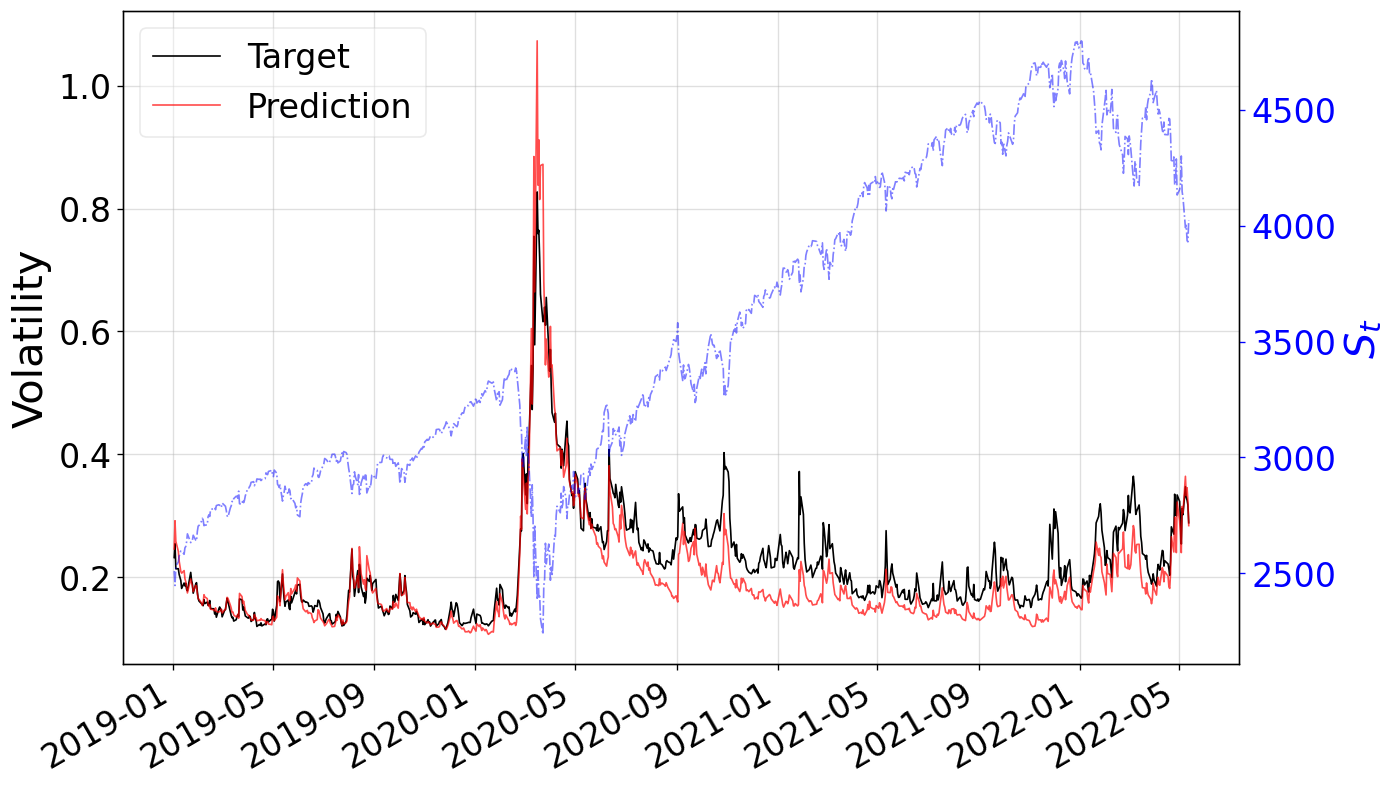

In [11]:
fig = plot_prediction_timeseries(y_target=target_on_test, y_pred=pred_on_test, index=index_on_test)

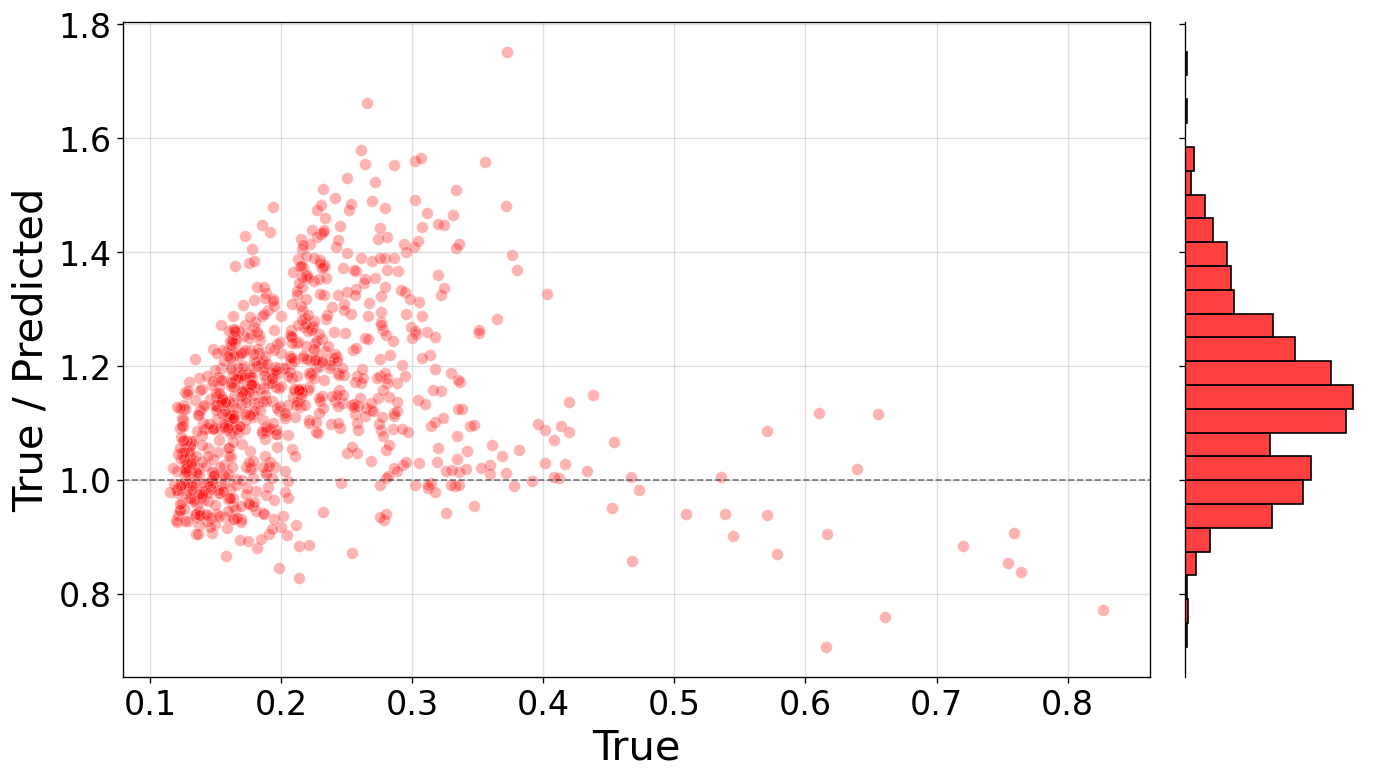

In [12]:
# Plot residuals on train set
fig = plot_prediction_vs_true(y_pred=pred_on_test, y_target=target_on_test, plot_residuals=True, ratio_residuals=True)

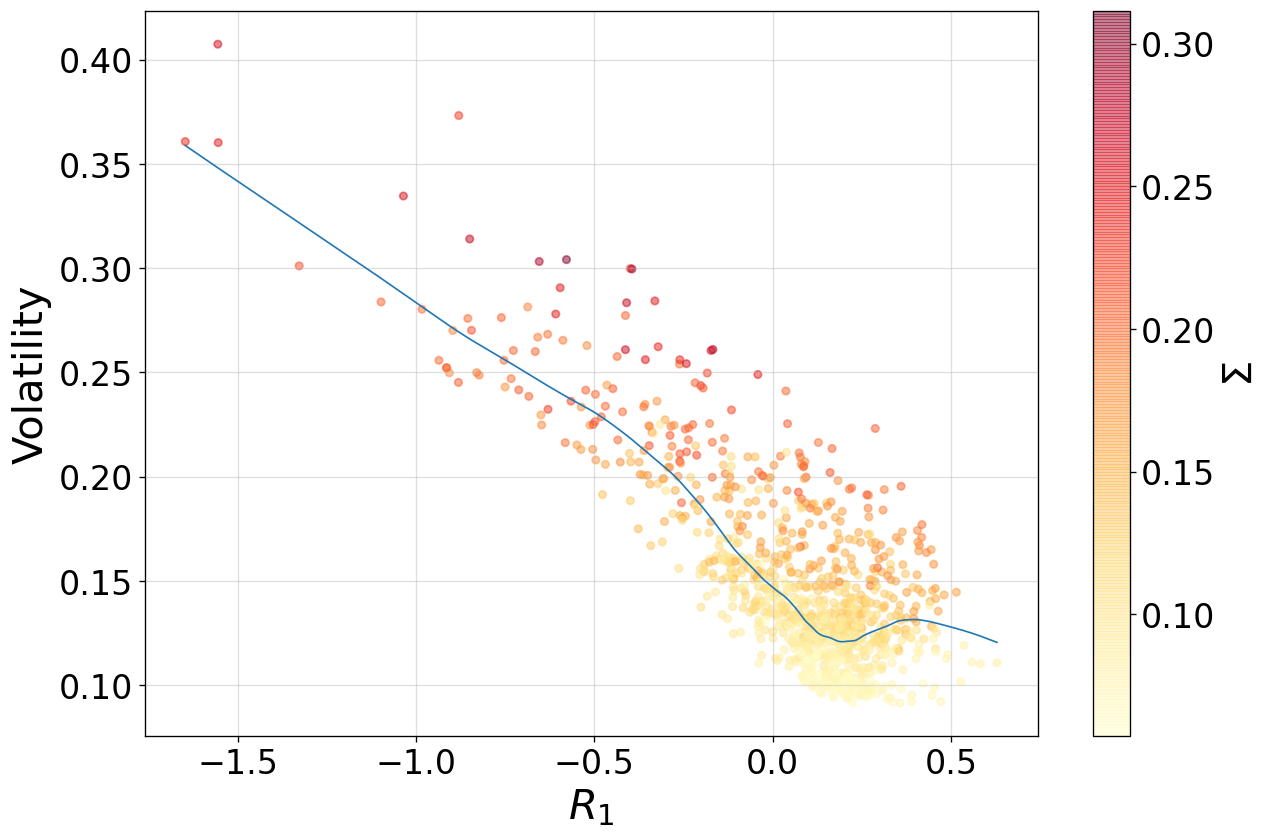

In [15]:
### Target vs Features
r_1_train = data_between_dates(sol['features']['R_1'], start_date=train_start_date, end_date=test_start_date)
sigma_train =  data_between_dates(sol['features']['R_2^0.5'], start_date=train_start_date, end_date=test_start_date)
fig = plot_vol_against_feature(feature=r_1_train, target=target_on_train, color_variable=sigma_train, 
                               color_label='$\Sigma$', feature_name='$R_1$')

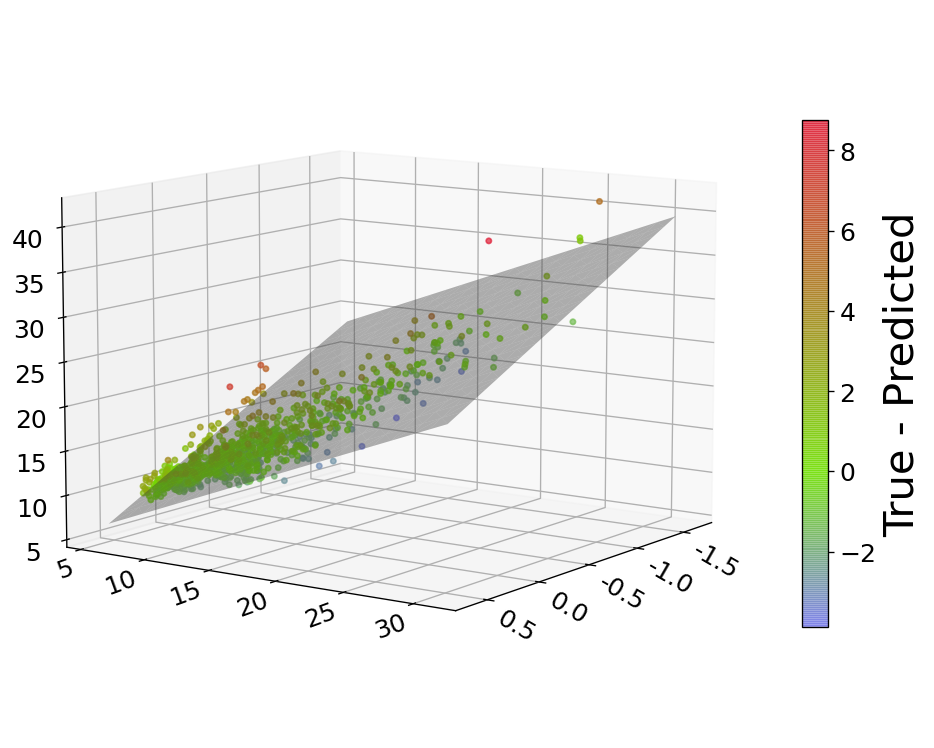

In [16]:
### 3D plot 
fig = plot_3d(X=r_1_train, Y=100*sigma_train, Z=100*target_on_train)